# An Introduction To Model Calibration With Probly

This notebook is a short introduction to post-processing calibration of neural networks with Probly.

# 0. Motivation and Intuition

A trained neural network might have good accuracy, but that is not all that we could wish for.  
Even if the accuracy of our model is good, it is possible that its confidence does not reflect the true likelyhood of the prediction being correct.

![Model Confidence](https://creatis-myriad.github.io/collections/images/calibration/reliability_histogram.jpg)

As you can see above models can be over or underconfident which means that they either overestimate or underestimate how accurate they are with their predictions.  

But it would be nice to have a good estimate of the accuracy via the confidence, especially in very sensitive areas like medicine or AI assisted driving...

# 1. What is Calibration

This is where calibration - and in this case post-processing calibration - comes in.  
Calibration aims to push the confidence the model gives us to reflect the true accuracy for the inputs. So a perfectly calibrated model would give you a confidence and you would know that is also its accuracy.  

There are two major ways to do calibration on neural networks:
- In-training calibration
- Post-processing calibration

In-training calibration methods would include certain loss functions like focal loss or a regularization method like dropout but we will focus on post-processing calibration since it can be applied to an already trained model withoud the need to modify or retrain it. 

# 2. Calibration with Probly

Probly once again really simplifies the whole process by giving us the `Calibrator` classes for the various frameworks.  
But to look at some calibrations we need something to calibrate in the first place, so lets define a model for that we can use. We will be using torch here, but other frameworks work just the same.

## 2.1 Load the model

We are going to use the pretrained ResNet18 Model from Torchvision for simplicity.

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models import ResNet18_Weights
import torchvision.transforms as T
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

net = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
net.fc = nn.Linear(512, 10, device=device)
net = net.to(device)

Using device: cpu


## 2.2 Load the data

Here we are going to load the CIFAR10 dataset from torchvision to do a quick training session...

In [3]:
transforms = T.Compose([T.ToTensor()])

train = torchvision.datasets.CIFAR10(root="~/datasets", train=True, download=True, transform=transforms)
train, cal = torch.utils.data.random_split(train, [0.8, 0.2])
test = torchvision.datasets.CIFAR10(root="~/datasets", train=False, download=True, transform=transforms)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
cal_loader = DataLoader(cal, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

## 2.3 Train the model

So let's give the model a quick training session with our dataset.

In [4]:
epochs = 5
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()
for epoch in tqdm(range(epochs)):
    net.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Running loss: {running_loss / len(train_loader)}")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:45<11:00, 165.20s/it]

Epoch 1, Running loss: 0.9172156403778465


 40%|████      | 2/5 [06:21<09:46, 195.49s/it]

Epoch 2, Running loss: 0.5583029228031255


 60%|██████    | 3/5 [09:48<06:40, 200.49s/it]

Epoch 3, Running loss: 0.4144916456596107


 80%|████████  | 4/5 [13:10<03:21, 201.10s/it]

Epoch 4, Running loss: 0.31458614311020844


100%|██████████| 5/5 [16:36<00:00, 199.24s/it]

Epoch 5, Running loss: 0.25396343016890205


## 2.4 A quick look at the model

For evaluation purposes probly gives us the function `expected_calibration_error()` to give us an idea of how uncalibrated the model really is.  
Now that we have something to work with, lets take a quick look at the calibration error of the uncalibrated model...

100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Accuracy: 0.8007
Expected Calibration Error: 0.08923756164908411
Brier Score: 0.29890820384025574


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Regular Model'}, xlabel='Confidence', ylabel='Accuracy'>)

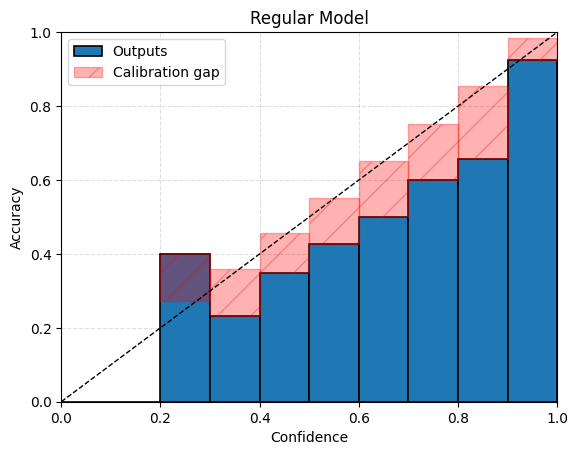

In [5]:
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score, expected_calibration_error

net.eval()
with torch.no_grad():
    outputs = torch.empty(0, device=device)
    targets = torch.empty(0, device=device)
    for inpt, target in tqdm(test_loader):
        outputs = torch.cat((outputs, net(inpt.to(device))), dim=0)
        targets = torch.cat((targets, target.to(device)), dim=0)
outputs = F.softmax(outputs, dim=1)
correct = torch.sum(torch.argmax(outputs, dim=1) == targets).item()
total = targets.size(0)
outputs_np = outputs.cpu().numpy()
targets_np = targets.cpu().numpy().astype(int)
ece = expected_calibration_error(outputs_np, targets_np, num_bins=30)
print(f"Accuracy: {correct / total}")
print(f"Expected Calibration Error: {ece}")

brier_calibrated = brier_score(outputs_np, targets_np)
print(f"Brier Score: {brier_calibrated}")

diagram = compute_reliability_diagram(outputs_np, targets_np)
plot_reliability_diagram(diagram, "Regular Model")

# 3. Histogram Binning

## 3.1 What is Histogram Binning?

Histogram Binning is a simple non-parametric calibration method, where all uncalibrated predictions are divided into mutually exclusive bins. Every bin gets a calibrated score assigned, so that if a prediction falls into bin A for example, the prediction would be "calibrated" to the calibrated score of bin A.

## 3.2 Histogram Binning with Probly

Accuracy after Histogram Binning calibration: 0.8023
ECE after Histogram Binning calibration: 0.0331
Brier score after Histogram Binning calibration: 0.2965


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'After Histogram Binning'}, xlabel='Confidence', ylabel='Accuracy'>)

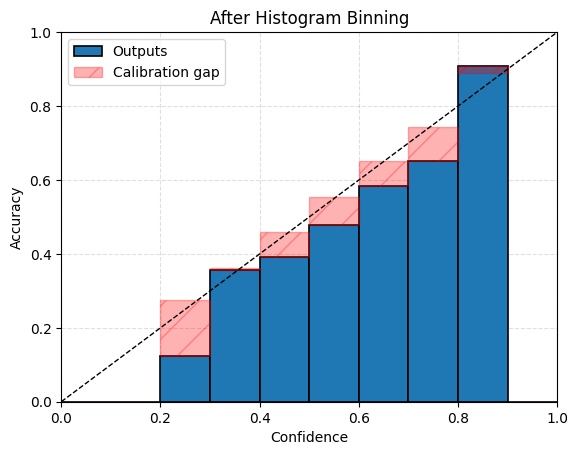

In [6]:
import torch
import torch.nn.functional as F

from probly.calibration.histogram_binning.torch import HistogramBinning
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score, expected_calibration_error

net.eval()

cal_probs_list, cal_targets_list = [], []
with torch.no_grad():
    for inputs, targets in cal_loader:
        logits = net(inputs)
        probs = F.softmax(logits, dim=1)
        cal_probs_list.append(probs)
        cal_targets_list.append(targets)
cal_probs = torch.cat(cal_probs_list, dim=0)
cal_targets = torch.cat(cal_targets_list, dim=0)
n_classes = cal_probs.shape[1]

calibrators = []
for class_idx in range(n_classes):
    class_probs = cal_probs[:, class_idx]
    binary_labels = (cal_targets == class_idx).long()

    if int(binary_labels.sum()) < 2:
        calibrators.append(None)
        continue

    calibrator = HistogramBinning(n_bins=10)
    calibrator.fit(class_probs, binary_labels)
    calibrators.append(calibrator)


test_probs_list, test_targets_list = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        logits = net(inputs)
        probs = F.softmax(logits, dim=1)
        test_probs_list.append(probs)
        test_targets_list.append(targets)

test_probs = torch.cat(test_probs_list, dim=0)
test_targets = torch.cat(test_targets_list, dim=0)


calibrated_probs = torch.zeros_like(test_probs)

for class_idx in range(n_classes):
    class_probs = test_probs[:, class_idx]
    calibrator = calibrators[class_idx]
    if calibrator is None or not getattr(calibrator, "is_fitted", False):
        calibrated_probs[:, class_idx] = class_probs
    else:
        calibrated_probs[:, class_idx] = calibrator.predict(class_probs)


row_sums = calibrated_probs.sum(dim=1, keepdim=True)
zero_rows = (row_sums == 0).squeeze()
if zero_rows.any():
    calibrated_probs[zero_rows] = test_probs[zero_rows]
    row_sums = calibrated_probs.sum(dim=1, keepdim=True)
calibrated_probs /= row_sums


calibrated_probs_np = calibrated_probs.numpy()
test_targets_np = test_targets.numpy()

accuracy = (calibrated_probs_np.argmax(axis=1) == test_targets_np).mean()
ece = expected_calibration_error(calibrated_probs_np, test_targets_np)
brier = brier_score(calibrated_probs_np, test_targets_np)

print(f"Accuracy after Histogram Binning calibration: {accuracy:.4f}")
print(f"ECE after Histogram Binning calibration: {ece:.4f}")
print(f"Brier score after Histogram Binning calibration: {brier:.4f}")

diagram = compute_reliability_diagram(calibrated_probs_np, test_targets_np)
plot_reliability_diagram(diagram, "After Histogram Binning")

# 4. Temperature Scaling

## 4.1 What is Temperature Scaling?

Temperature scaling is a simple way to make a model’s confidence more honest. Many machine learning models, especially neural networks, are good at predicting the right class but tend to be too confident about their answers. Temperature scaling fixes this by slightly adjusting the model’s output probabilities after training. It does this by dividing the model’s raw scores by a value called the temperature, which can make the probabilities softer and less extreme. A higher temperature makes the model more cautious, while a lower one makes it more confident. The best temperature is learned using a validation set. Importantly, this process doesn’t change what the model predicts—it only makes the confidence behind those predictions more realistic and easier to trust.

## 4.2 Temperature Scaling with Probly

This code applies temperature scaling to calibrate a neural network’s predicted probabilities by learning a temperature parameter on a separate calibration dataset while keeping the model weights fixed. After calibration, the model generates probability predictions on the test set, which are then evaluated using Expected Calibration Error (ECE) to measure the gap between confidence and accuracy, and the Brier Score to assess overall probabilistic accuracy. Finally, a reliability diagram is plotted to visually show how well the model’s predicted confidence aligns with actual performance, where predictions closer to the diagonal indicate better calibration.

In [ ]:
from probly.calibration.temperature_scaling import common
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score

model = common.Temperature(net, device)
model.fit(cal_loader, learning_rate=0.01, max_iter=100)

all_targets = []
all_probs = []
all_probs_before = []
net.eval()
with torch.no_grad():
    for inpt, target in test_loader:
        logits = net(inpt.to(device))
        probs = torch.softmax(logits, dim=1)
        all_probs_before.append(probs.cpu())

        all_probs.append(model.predict(inpt))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)
all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.detach().cpu().numpy()
all_targets_np = all_targets.detach().cpu().numpy()

ece_calibrated = expected_calibration_error(all_probs_np, all_targets_np, num_bins=10)
print(f"Expected Calibration Error, after Temperature Scaling: {ece_calibrated}")

brier_calibrated = brier_score(all_probs_np, all_targets_np)
print(f"Brier Score, after Temperature Scaling: {brier_calibrated}")

diagram = compute_reliability_diagram(all_probs_np, all_targets_np)
plot_reliability_diagram(diagram, "After Temperature Scaling")
diagram_before = compute_reliability_diagram(all_probs_before_np, all_targets_np)

# 5. Isotonic Regression

## 5.1 What is Isotonic Regression?

Isotonic Regression is one of the most common non-parametric post-processing calibration methods. It learns a piecewise constant function to transform uncalibrated model outputs and aims to minimize the square loss.  
It can be seen as a strict generalization of histogram binning.

## 5.2 Isotonic Regression with Probly

Let's calibrate our base model with probly's isotonic regression and again, compare it to the base model.

Expected Calibration Error after Isotonic Regression: 0.014937470574676995
Brier Score after Isotonic Regression: 0.2735291123390198


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Isotonic Regression'}, xlabel='Confidence', ylabel='Accuracy'>)

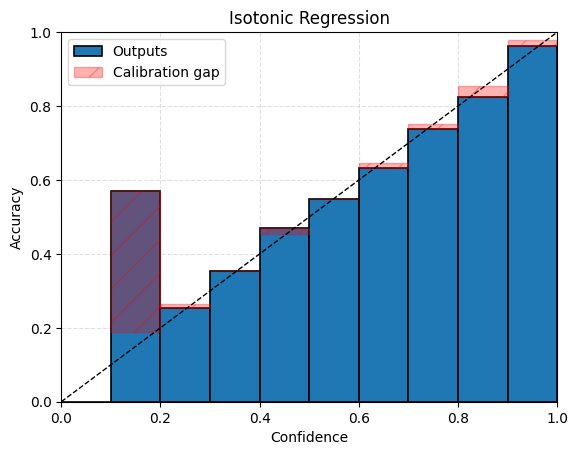

In [17]:
from probly.calibration.isotonic_regression.torch import IsotonicRegressionCalibrator

isotonic_regression_cal = IsotonicRegressionCalibrator(net, device)
isotonic_regression_cal.fit(cal_loader)

cal_probs_isotonic = []
labels_isotonic = []
with torch.no_grad():
    for x_to_device, y in test_loader:
        x = x_to_device.to(device)
        p = isotonic_regression_cal.predict(x)
        cal_probs_isotonic.append(p.cpu())
        labels_isotonic.append(y.cpu())

cal_probs_isotonic = torch.cat(cal_probs_isotonic).numpy()
all_labels_isotonic = torch.cat(labels_isotonic).numpy()

ece_calibrated_isotonic = expected_calibration_error(cal_probs_isotonic, all_labels_isotonic)
print(f"Expected Calibration Error after Isotonic Regression: {ece_calibrated_isotonic}")

brier_calibrated_isotonic = brier_score(cal_probs_isotonic, all_labels_isotonic)
print(f"Brier Score after Isotonic Regression: {brier_calibrated_isotonic}")

diagram_isotonic = compute_reliability_diagram(cal_probs_isotonic, all_labels_isotonic)
plot_reliability_diagram(diagram_isotonic, "Isotonic Regression")

As we can see, the isotonic regression calibrated the models outputs and the brier score should have decreased. The ECE might not necessarily decrease since isotonic regression can over fit and thus slightly increase the ECE.

# 6. Bayesian Binning into Quantiles (BBQ)

## 6.1 What is BBQ?

Bayesian Binning Quantiles is an advanced non-parametric calibration method that improves upon simple histogram binning by combining multiple binning models weighted according to their posterior probabilities. Instead of using a single fixed number of bins, BBQ explores many possible bin partitions and averages their calibrated outputs in a Bayesian manner. This helps provide more robust and accurate calibration, especially when data is limited or noisy.

## 6.2 BBQ with Probly

Here's how we can implement BBQ Calibration with probly:

D:\Study\SEP\myprobly\probly\src\probly\calibration\bayesian_binning\torch.py:51: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  bin_ids = torch.bucketize(calibration_set, edges) - 1


Accuracy after BBQ calibration: 0.8011
ECE after BBQ calibration: 0.0197
Brier score after BBQ calibration: 0.2904


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'After Bayesian Binning Quantiles Calibration'}, xlabel='Confidence', ylabel='Accuracy'>)

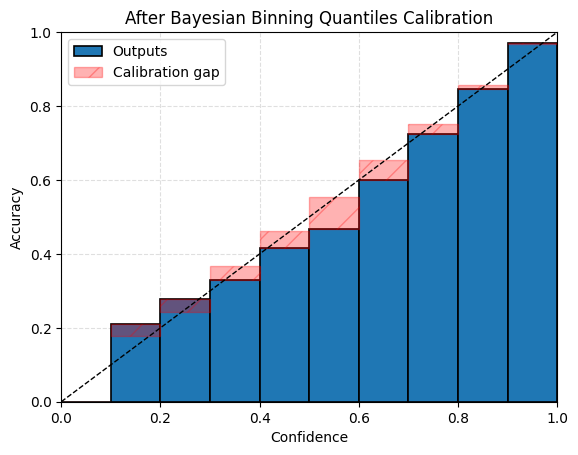

In [ ]:
import torch
import torch.nn.functional as F

from probly.calibration.bayesian_binning.torch import BayesianBinningQuantiles
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score, expected_calibration_error

net.eval()

cal_logits_list, cal_targets_list = [], []
with torch.no_grad():
    for inputs, targets in cal_loader:
        outputs = net(inputs)
        cal_logits_list.append(outputs)
        cal_targets_list.append(targets)
cal_logits = torch.cat(cal_logits_list, dim=0)
cal_targets = torch.cat(cal_targets_list, dim=0)


cal_probs = F.softmax(cal_logits, dim=1)
n_classes = cal_probs.shape[1]
bbq_calibrators = [None] * n_classes

for class_idx in range(n_classes):
    class_probs = cal_probs[:, class_idx]
    binary_labels = (cal_targets == class_idx).long()

    if int(binary_labels.sum()) < 2:
        bbq_calibrators[class_idx] = None
        continue

    calibrator = BayesianBinningQuantiles(max_bins=10)
    calibrator.fit(class_probs, binary_labels)

    if not getattr(calibrator, "is_fitted", False):
        bbq_calibrators[class_idx] = None
    else:
        bbq_calibrators[class_idx] = calibrator

test_logits_list, test_targets_list = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = net(inputs)
        test_logits_list.append(outputs)
        test_targets_list.append(targets)

test_logits = torch.cat(test_logits_list, dim=0)
test_targets = torch.cat(test_targets_list, dim=0)

test_probs = F.softmax(test_logits, dim=1)

calibrated_probs = torch.zeros_like(test_probs, dtype=torch.float32)

for class_idx in range(n_classes):
    class_probs = test_probs[:, class_idx]
    calibrator = bbq_calibrators[class_idx]
    if calibrator is None or not getattr(calibrator, "is_fitted", False):
        calibrated_probs[:, class_idx] = class_probs
    else:
        preds = calibrator.predict(class_probs)
        calibrated_probs[:, class_idx] = preds

row_sums = calibrated_probs.sum(dim=1, keepdim=True)
zero_rows = (row_sums == 0).squeeze()
if zero_rows.any():
    calibrated_probs[zero_rows] = test_probs[zero_rows]
    row_sums = calibrated_probs.sum(dim=1, keepdim=True)
calibrated_probs /= row_sums

calibrated_probs_np = calibrated_probs.numpy()
test_targets_np = test_targets.numpy()

accuracy = (calibrated_probs_np.argmax(axis=1) == test_targets_np).mean()
ece = expected_calibration_error(calibrated_probs_np, test_targets_np)
brier = brier_score(calibrated_probs_np, test_targets_np)

print(f"Accuracy after BBQ calibration: {accuracy:.4f}")
print(f"ECE after BBQ calibration: {ece:.4f}")
print(f"Brier score after BBQ calibration: {brier:.4f}")

diagram = compute_reliability_diagram(calibrated_probs_np, test_targets_np)
plot_reliability_diagram(diagram, "After Bayesian Binning Quantiles Calibration")

In [1]:
from probly.calibration.bayesian_binning.torch2 import BayesianBinningQuantiles
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score, expected_calibration_error

bbq_calibrator = BayesianBinningQuantiles(multi_class=True, max_bins=10)

cal_logits_list, cal_targets_list = [], []
with torch.no_grad():
    for inputs, targets in cal_loader:
        outputs = net(inputs)
        cal_logits_list.append(outputs)
        cal_targets_list.append(targets)

cal_logits = torch.cat(cal_logits_list, dim=0)
cal_targets = torch.cat(cal_targets_list, dim=0)
cal_probs = F.softmax(cal_logits, dim=1)

bbq_calibrator.fit(cal_probs, cal_targets)

# --- Step 2: Predict calibrated probabilities on test data batch by batch ---

calibrated_probs_list = []
test_targets_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = net(inputs)  # logits
        probs = F.softmax(outputs, dim=1)  # uncalibrated probs

        calibrated = bbq_calibrator.predict(probs)
        calibrated_probs_list.append(calibrated.cpu())
        test_targets_list.append(targets.cpu())

calibrated_probs = torch.cat(calibrated_probs_list).numpy()
test_targets = torch.cat(test_targets_list).numpy()

# --- Step 3: Evaluate metrics ---

accuracy = (calibrated_probs.argmax(axis=1) == test_targets).mean()
ece = expected_calibration_error(calibrated_probs, test_targets)
brier = brier_score(calibrated_probs, test_targets)

print(f"Accuracy after BBQ calibration: {accuracy:.4f}")
print(f"ECE after BBQ calibration: {ece:.4f}")
print(f"Brier score after BBQ calibration: {brier:.4f}")

# --- Step 4: Plot reliability diagram ---

diagram = compute_reliability_diagram(calibrated_probs, test_targets)
plot_reliability_diagram(diagram, "After Bayesian Binning Quantiles Calibration")


NameError: name 'torch' is not defined